In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import dataframe_image as difi
import warnings

# ignore some warnings that are not relavent
warnings.filterwarnings('ignore') 

filename = "heart_failure_clinical_records_dataset.csv" # The csv file with the heart failure data
# Get the data into a dataframe and set some data as categorical datatypes
clinical_df = pd.read_csv(filename)
categorical_columns = ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking", "DEATH_EVENT"]
clinical_df[categorical_columns] = clinical_df[categorical_columns].astype("category")

In [2]:
clinical_df.describe()
#difi.export(clinical_df.describe(), "data_description.png")

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
count,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000
mean,60.833893,581.839465,38.083612,263358.029264,1.39388,136.625418,130.260870
std,11.894809,970.287881,11.834841,97804.236869,1.03451,4.412477,77.614208
min,40.000000,23.000000,14.000000,25100.000000,0.50000,113.000000,4.000000
25%,51.000000,116.500000,30.000000,212500.000000,0.90000,134.000000,73.000000
50%,60.000000,250.000000,38.000000,262000.000000,1.10000,137.000000,115.000000
75%,70.000000,582.000000,45.000000,303500.000000,1.40000,140.000000,203.000000
max,95.000000,7861.000000,80.000000,850000.000000,9.40000,148.000000,285.000000


In [3]:
clinical_df.select_dtypes("number").columns

Index(['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets',
       'serum_creatinine', 'serum_sodium', 'time'],
      dtype='object')

In [4]:
clinical_df.select_dtypes("category").columns

Index(['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking',
       'DEATH_EVENT'],
      dtype='object')

In [5]:
clinical_df.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [6]:
survived = clinical_df[clinical_df["DEATH_EVENT"] == 0]["DEATH_EVENT"].count()
died = clinical_df[clinical_df["DEATH_EVENT"] == 1]["DEATH_EVENT"].count()

# Ouput the amount of survived and died in the follow up period
print("Amount that survived in the follow up period is {} ({:.0f}%)".format(
    survived, 
    100*survived/len(clinical_df)))
print("Amount that died in the follow up period is {} ({:.0f}%)".format(
    died, 
    100*died/len(clinical_df)))

Amount that survived in the follow up period is 203 (68%)
Amount that died in the follow up period is 96 (32%)


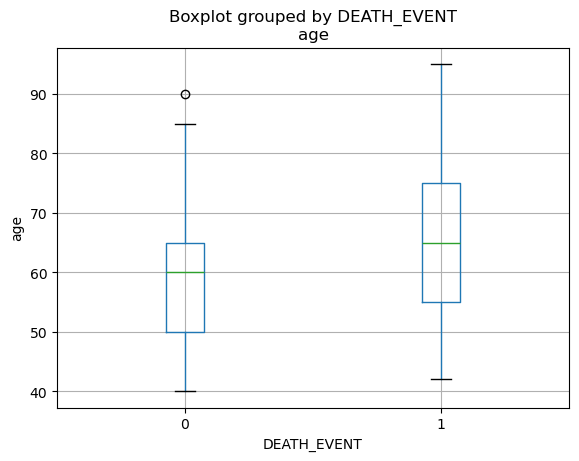

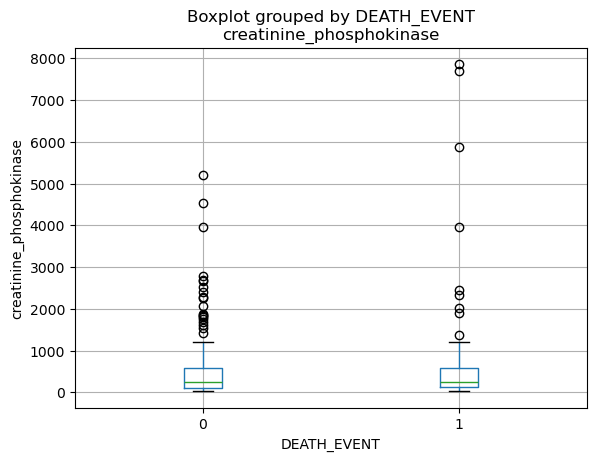

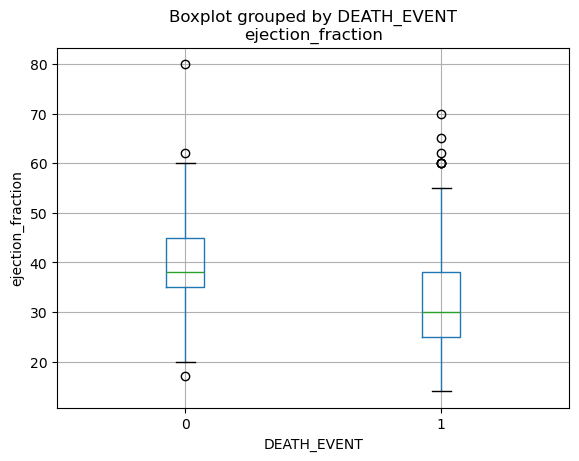

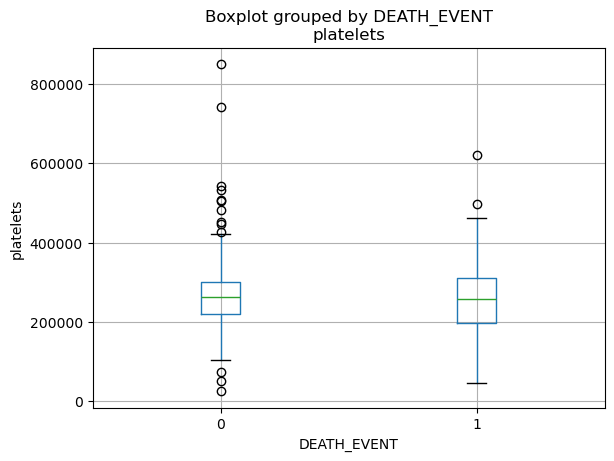

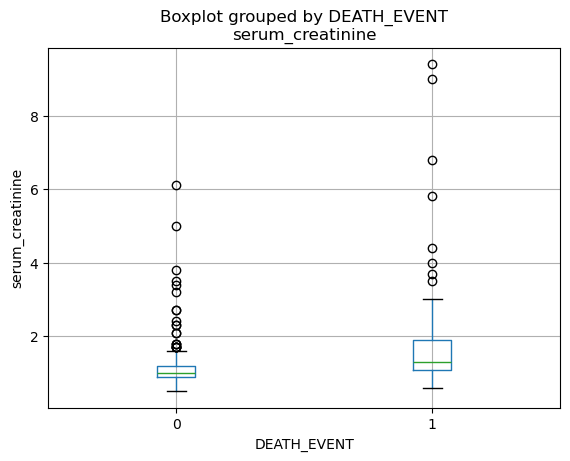

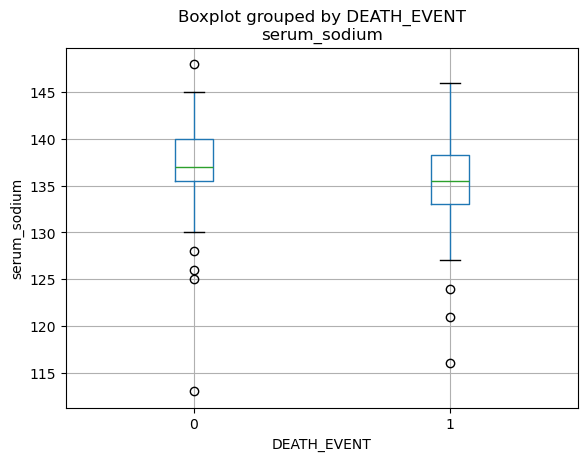

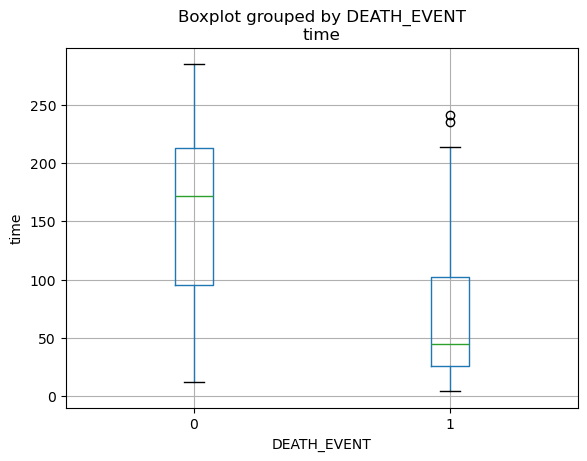

In [7]:
for column in clinical_df.columns:
    if column not in clinical_df.select_dtypes("category").columns:
        clinical_df.boxplot(column, ylabel = column, by = "DEATH_EVENT")

In [8]:
def get_stats_with_hist(df, column, group_by = "DEATH_EVENT", bins = 6):
    print("%s data statistics:" % column)
    print(df[column].describe())
    print("----------------------------------------------------------\n")
    print("Data Statistics by {} for {}".format(group_by, column))
    print(df.groupby(by = group_by)[column].describe())
    print("----------------------------------------------------------\n\n")

    ### Makes histograms of the column data grouped by the groupby column
    for group, indicies in df.groupby(by = group_by)[column].groups.items():
        df2 = df.loc[indicies, :]
        sns.histplot(df2, x = "age", bins = 6, kde = True)

#get_stats(clinical_df, "age")

age data statistics:
count    299.000000
mean      60.833893
std       11.894809
min       40.000000
25%       51.000000
50%       60.000000
75%       70.000000
max       95.000000
Name: age, dtype: float64
----------------------------------------------------------

Data Statistics by DEATH_EVENT for age
             count       mean        std   min   25%   50%   75%   max
DEATH_EVENT                                                           
0            203.0  58.761906  10.637890  40.0  50.0  60.0  65.0  90.0
1             96.0  65.215281  13.214556  42.0  55.0  65.0  75.0  95.0
----------------------------------------------------------




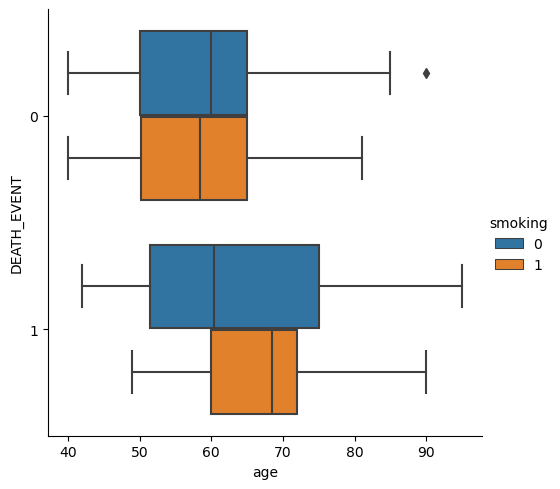

In [9]:
def get_stats_with_box(df, column, group_by = "DEATH_EVENT", hue = None):
    print("%s data statistics:" % column)
    print(df[column].describe())
    print("----------------------------------------------------------\n")
    print("Data Statistics by {} for {}".format(group_by, column))
    print(df.groupby(by = group_by)[column].describe())
    print("----------------------------------------------------------\n\n")

    ### Makes histograms of the column data grouped by the groupby column
    sns.catplot(df, x = column, y = group_by, kind = "box", hue = hue)
get_stats_with_box(clinical_df, "age", hue = "smoking")

# Data & Plot Analysis

Looking at the box plots above one at a time we can see that those that died during the follow-up period:<br>
- Were older than those that didn't.<br>
- Had higher levels of creatinine phosphokinase (CPK) about 130 mcg/L greater on average with a much higher standard deviation.
   According to the dataset description, high levels of CPK may indicate heart failure or injury.<br>
- Had a lower average percentage of blood pumped out by the left ventricle with each contraction (lower ejection fraction).<br>
- Had similar platelet count average and standard deviation to those that survived (measured in kiloplatelets/mL).<br>
- Had slightly hihger levels in serum creatinine with a much larger standard deviation. High levels may indicate
  renal dysfunction.<br>
- Had similar average and deviation in the serum sodium measurements (mEq/L). Abnormal levels indicate heart failure.
- Had a lower average number of days before a follow-up was conducted. Which makes sense if a death event happened before the intended follow period.

# Principal Component Analysis & K-means Klustering

In [10]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# Get the numeric columns for PCA
numeric_df = clinical_df.select_dtypes("number")
# Scale the data and perform PCA
scaled_df = pd.DataFrame(data = StandardScaler().fit_transform(numeric_df), columns = numeric_df.columns)
pca = PCA()
pca.fit(scaled_df)

# Create a dataframe from the PCA data
pca_columns = list()
for i in range(pca.n_components_):
    pca_columns.append("PC{}".format(i+1))
    
# Print the dataframe of principal components
pca_df = pd.DataFrame(data = np.transpose(pca.components_), columns = pca_columns, index = numeric_df.columns)

In [11]:
def color_negative(v):
    return "background-color: #faf31e;" if abs(v) >= 0.3 else "background-color: #92a8d1;"

# Prints the dataframe with 'significant' values highlighted as yellow
pca_styled = pca_df.iloc[:, 0:len(numeric_df.columns)].style.applymap(color_negative, subset=pca_df.columns[:len(numeric_df.columns)])
#difi.export(pca_styled, "PCs.png")
pca_styled

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
age,0.464962,0.452132,-0.007800,-0.198092,-0.191214,-0.634138,-0.318422
creatinine_phosphokinase,-0.137959,-0.193893,0.815054,-0.334406,0.294822,-0.100879,-0.264833
ejection_fraction,-0.178892,0.681478,-0.106713,-0.012995,0.469486,0.391348,-0.344178
platelets,-0.199258,0.246786,0.403317,0.820954,-0.180756,-0.173305,-0.007459
serum_creatinine,0.511777,0.045696,0.101672,0.182265,0.633580,-0.106913,0.528757
serum_sodium,-0.447411,0.429720,0.117976,-0.362607,-0.151399,-0.186519,0.641912
time,-0.480603,-0.214286,-0.370565,0.100469,0.446186,-0.598569,-0.135358


Cumulative sum of variance explained: [0.21065323 0.37859486 0.52566331 0.66369556 0.79051471 0.89586366
 1.        ]


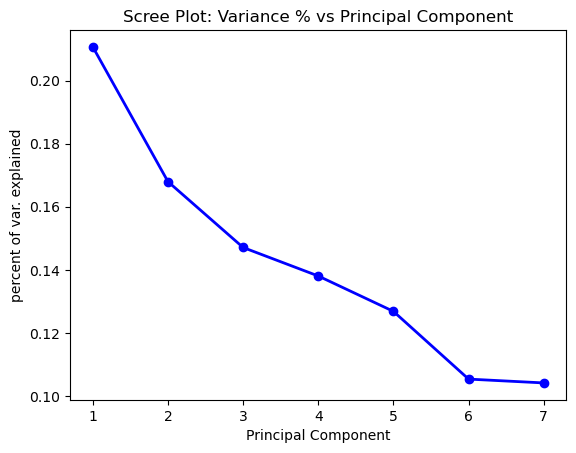

In [12]:
pca_vals = np.arange(pca.n_components_) + 1
print("Cumulative sum of variance explained:", np.cumsum(pca.explained_variance_ratio_))
plt.plot(pca_vals, pca.explained_variance_ratio_, "bo-", linewidth=2)
_ = plt.title("Scree Plot: Variance % vs Principal Component")
_ = plt.xlabel("Principal Component")
_ = plt.ylabel("percent of var. explained")
#plt.savefig("initial_scree_plot.png")

In [13]:
# KMeans Scree Plot
n = 20
inertias = list()
for i in range(1,n+1):
    kmeans = KMeans(i, n_init = 'auto', random_state=4990).fit(scaled_df)
    inertias.append(kmeans.inertia_)

          inertias
count    20.000000
mean   1071.808214
std     409.257413
min     681.081473
25%     772.143869
50%     902.868165
75%    1234.388068
max    2093.000000


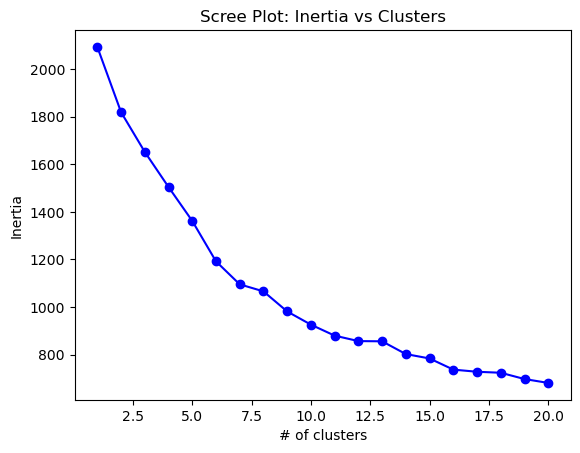

In [14]:
n = 20
print(pd.DataFrame(inertias, columns = ["inertias"]).describe())
_ = plt.plot( [i for i in range(1,n+1)], inertias, "bo-")
_ = plt.title("Scree Plot: Inertia vs Clusters")
_ = plt.xlabel("# of clusters")
_ = plt.ylabel("Inertia")

## PCA & Kmeans Analysis
From above we can see that for this data choosing 4 or 6 clusters using the PCA transformed data would be reaonsable to capture the variance of the orignial data and yield a number of cluster than can be interpreted.

In [15]:
n = 6
# Get the pca transformed data of scaled_df (scaled numeric data only ... does not include scaled categorical data)
pca_preds = pd.DataFrame(data = pca.transform(scaled_df), columns = pca_columns)
#kmeans = KMeans(n, n_init = 'auto',random_state=4990).fit(pca_preds)
kmeans = KMeans(n, n_init = 'auto',random_state=4990).fit(StandardScaler().fit_transform(clinical_df))
columns = pca_preds.columns

In [16]:
'''
grab the first columns of the pca object which represents the first coefficients for pc1.
grab the first row of patinet values.
perform the dot product
'''
clin_df = pd.concat([clinical_df, pca_preds, pd.DataFrame(data = kmeans.labels_, columns = ["cluster"])], axis = 1)
clin_df['cluster'] = clin_df['cluster'].astype("category")
clin_df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,...,time,DEATH_EVENT,PC1,PC2,PC3,PC4,PC5,PC6,PC7,cluster
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,...,4,1,2.531972,-0.774297,0.637166,0.268306,-1.138535,-0.154896,-0.339017,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,...,6,1,-0.575241,-1.414350,6.678012,-2.577033,1.431765,0.567526,-1.855774,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,...,7,1,2.198351,-1.460498,-0.248777,-0.300059,-1.235973,0.688621,-0.401945,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,...,7,1,1.002843,-1.096338,0.203218,-0.186807,-1.000820,1.007247,1.479127,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,...,8,1,3.867550,-2.255242,0.229436,2.400883,-0.225751,0.792090,-1.597727,1


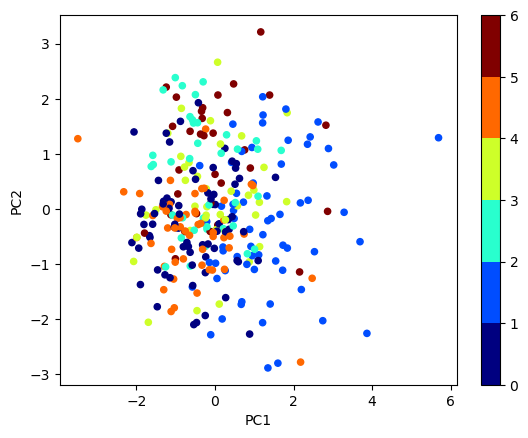

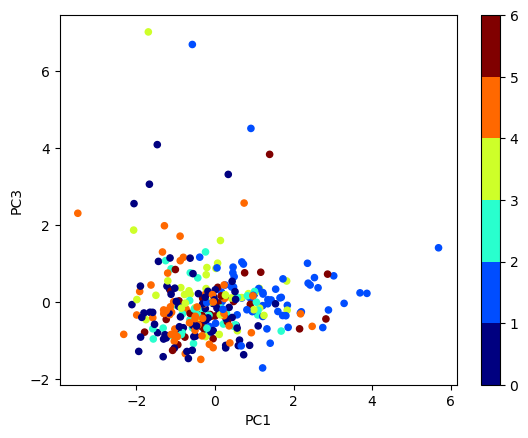

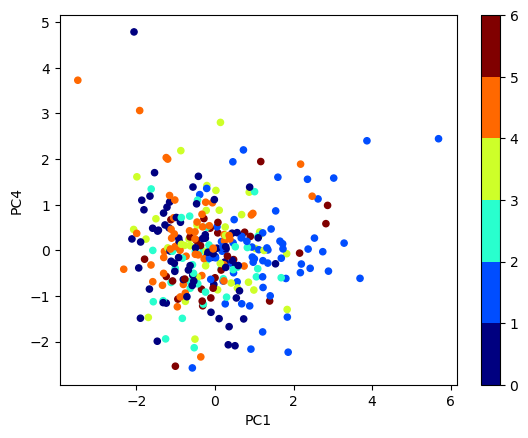

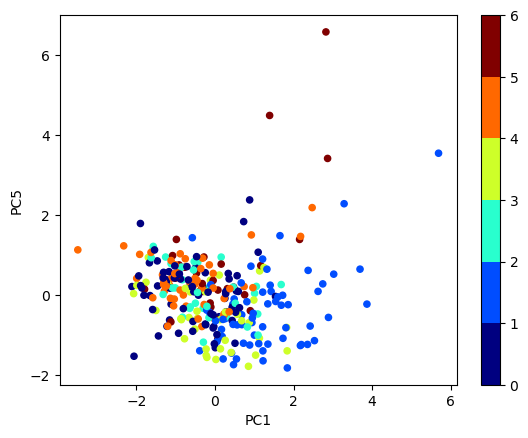

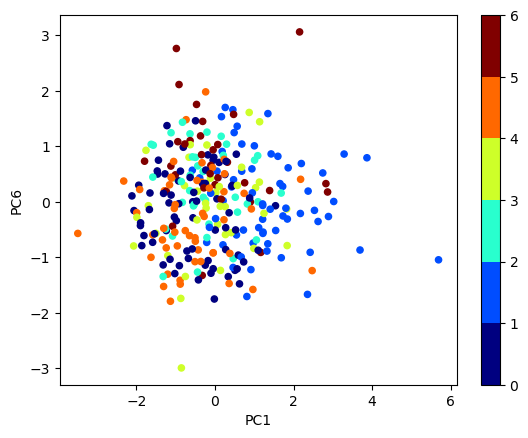

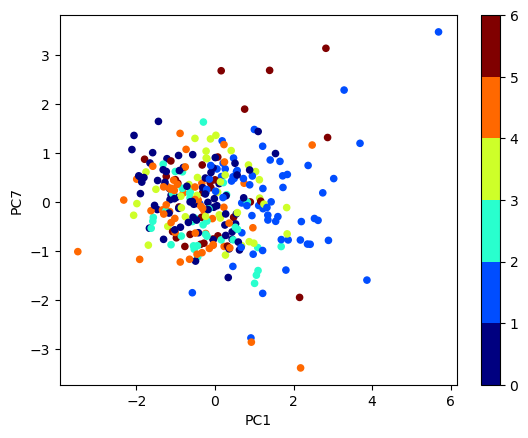

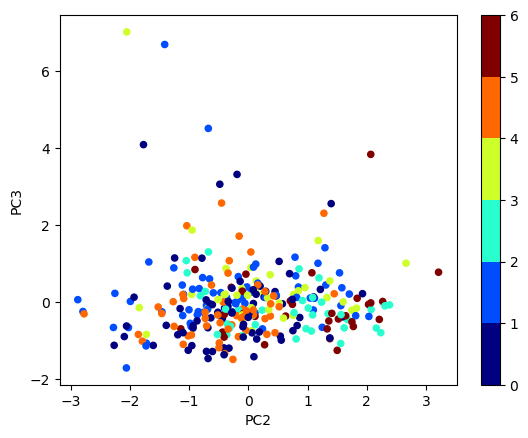

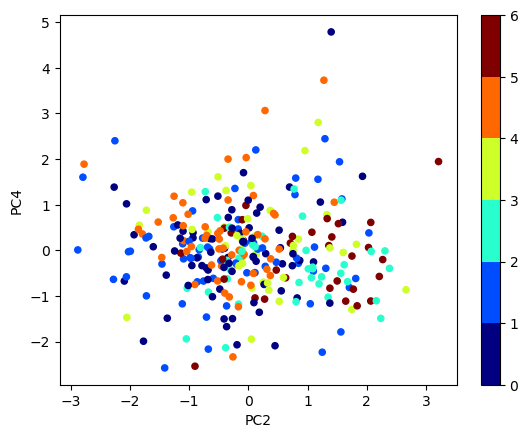

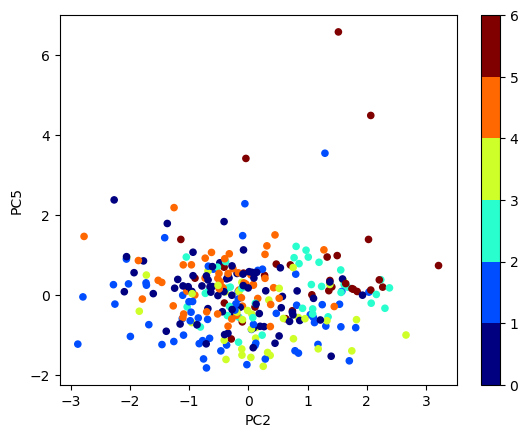

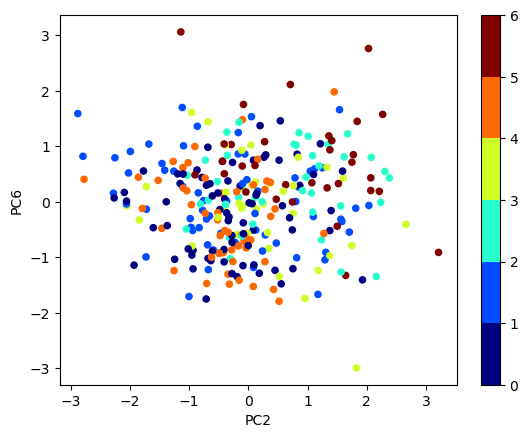

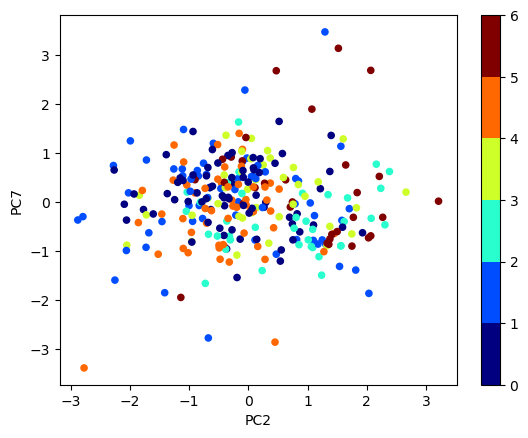

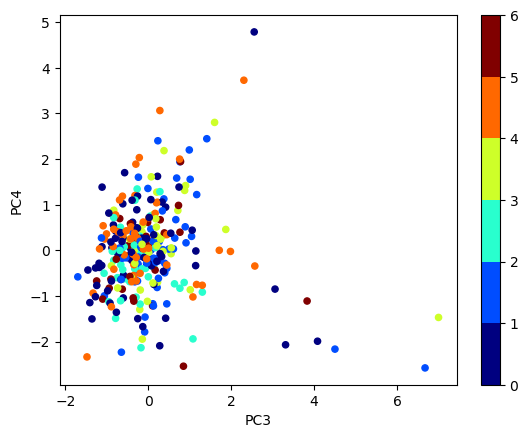

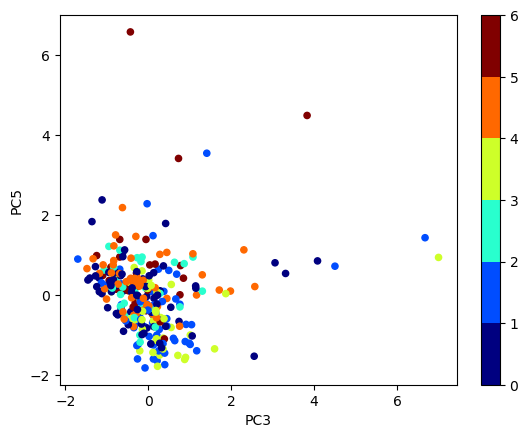

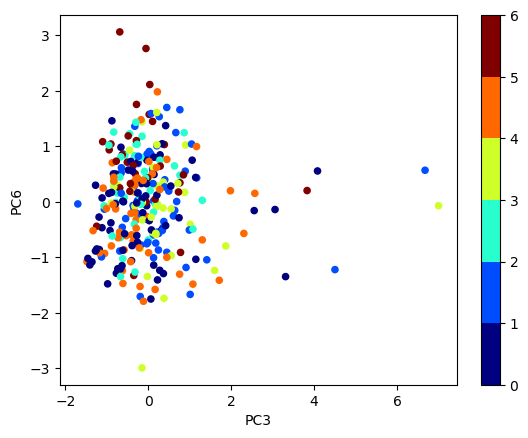

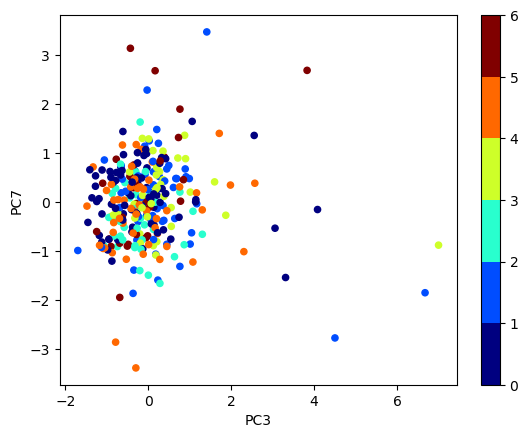

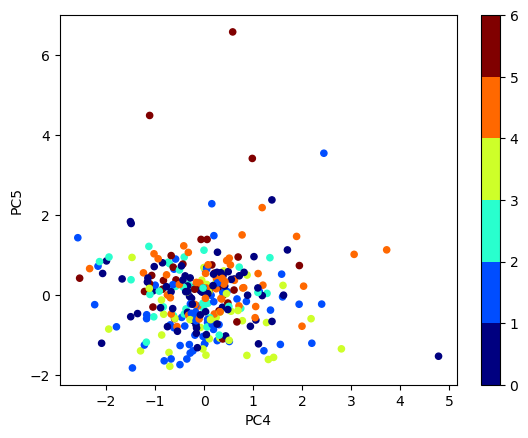

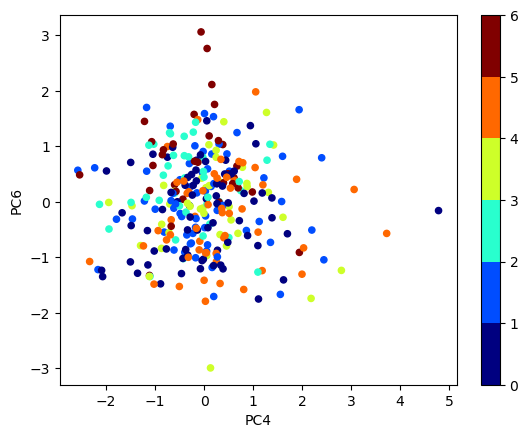

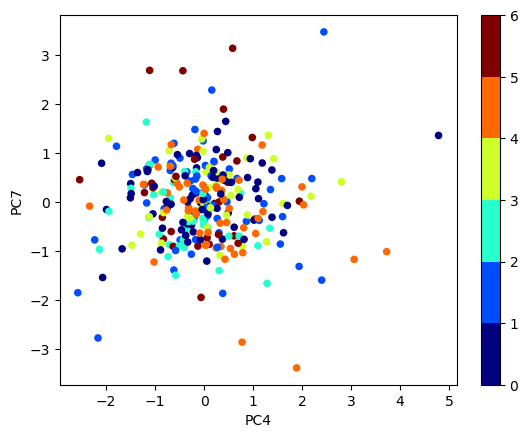

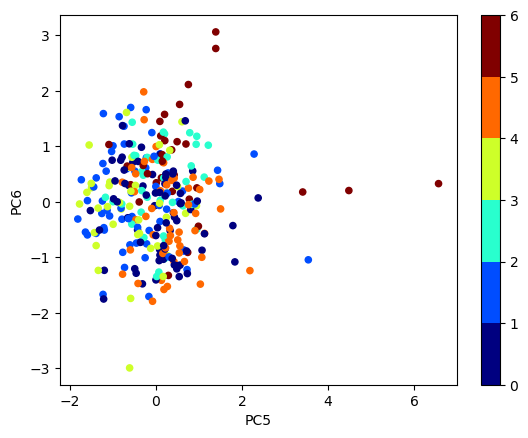

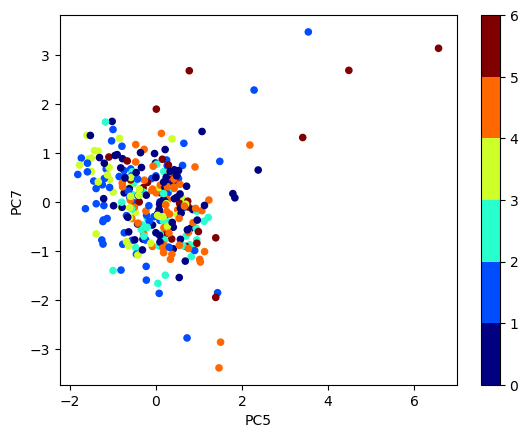

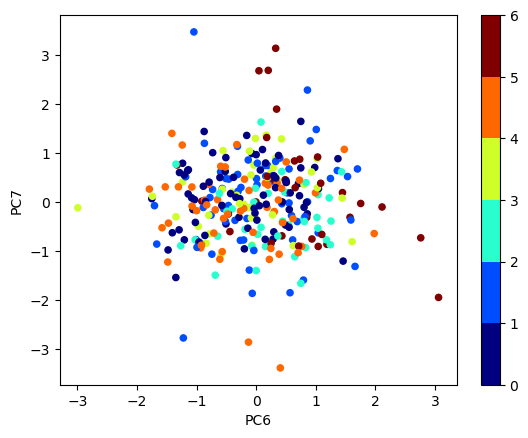

In [17]:
import matplotlib as mpl
# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0,n,n+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

for idx1 in range(len(columns)):
    for idx2 in range(len(columns)):
        if idx1 < idx2:
            clin_df.plot.scatter(columns[idx1], columns[idx2], 
                                   c = kmeans.labels_, cmap = cmap,
                                   norm = norm, legend = True)

In [32]:
for cluster in range(n):
    mask = (clin_df["cluster"] == cluster)
    avg = clin_df[mask]["DEATH_EVENT"].astype(int).mean()
    
    print("Cluster {} has {} people Death Event Percentage: {:.3f}%".format(cluster, np.sum(mask), 100*np.round(avg, 3)))

Cluster 0 has 73 people Death Event Percentage: 4.100%
Cluster 1 has 64 people Death Event Percentage: 98.400%
Cluster 2 has 38 people Death Event Percentage: 2.600%
Cluster 3 has 39 people Death Event Percentage: 43.600%
Cluster 4 has 53 people Death Event Percentage: 3.800%
Cluster 5 has 32 people Death Event Percentage: 31.200%


In [19]:
# A dataframe holding the percentage of max pc percentage values within a cluster
clust_dist_df = pd.DataFrame(data = [], 
                             index = pca_df.columns,
                             columns = ["clust{}".format(i) for i in range(n)])
for cluster in range(n):
    pca_columns  = pca_df.columns # names of the principal components
    temp_df = clin_df[list(pca_columns) + ["cluster"]] # A dataframe of the PC transformed data
    # A dataframe that has a single column of which PC was the maximum
    max_df = pd.DataFrame(data = temp_df[temp_df["cluster"] == cluster][pca_columns]\
                          .idxmax(axis = 1), 
                          columns=["max"])
    # a dataframe that is the PCA transoformed values and a column of the max labels
    #max_df[pca_columns] = clin_df[pca_columns]
    
    for pc in columns:
        mask = (max_df["max"] == pc)
        avg = len(max_df[mask])/len(max_df)
        clust_dist_df["clust{}".format(cluster)][pc] = "{:.1f}%".format(np.round(avg,3)*100)#100*np.round(avg,3)
clust_dist_df
# for col in clust_dist_df.columns:
#     print(clust_dist_df[col].sum())

,clust0,clust1,clust2,clust3,clust4,clust5
PC1,8.2%,53.1%,15.8%,23.1%,11.3%,3.1%
PC2,11.0%,10.9%,36.8%,23.1%,3.8%,43.8%
PC3,9.6%,7.8%,7.9%,5.1%,11.3%,3.1%
PC4,15.1%,7.8%,13.2%,20.5%,22.6%,0.0%
PC5,17.8%,0.0%,10.5%,2.6%,28.3%,9.4%
PC6,19.2%,7.8%,13.2%,10.3%,9.4%,28.1%
PC7,19.2%,12.5%,2.6%,15.4%,13.2%,12.5%


In [20]:
# A dataframe holding the percentage of max pc percentage values within a cluster
clust_dist_df = pd.DataFrame(data = [], 
                             index = pca_df.columns,
                             columns = ["clust{}".format(i) for i in range(n)])
for cluster in range(n):
    pca_columns  = pca_df.columns # names of the principal components
    temp_df = clin_df[list(pca_columns) + ["cluster"]] # A dataframe of the PC transformed data
    # A dataframe that has a single column of which PC was the minimum
    max_df = pd.DataFrame(data = temp_df[temp_df["cluster"] == cluster][pca_columns]\
                          .idxmin(axis = 1), 
                          columns=["min"])
    # a dataframe that is the PCA transoformed values and a column of the max labels
    #max_df[pca_columns] = clin_df[pca_columns]
    
    for pc in columns:
        mask = (max_df["min"] == pc)
        avg = len(max_df[mask])/len(max_df)
        clust_dist_df["clust{}".format(cluster)][pc] = "{:.1f}%".format(np.round(avg,3)*100)
clust_dist_df

#print("Run This code cell for the dataframe with the lowest pc value percentages in a given cluster")

,clust0,clust1,clust2,clust3,clust4,clust5
PC1,34.2%,0.0%,26.3%,20.5%,28.3%,18.8%
PC2,17.8%,35.9%,5.3%,12.8%,22.6%,6.2%
PC3,9.6%,0.0%,10.5%,5.1%,7.5%,12.5%
PC4,12.3%,9.4%,21.1%,10.3%,5.7%,21.9%
PC5,9.6%,25.0%,2.6%,38.5%,3.8%,9.4%
PC6,12.3%,18.8%,7.9%,7.7%,20.8%,6.2%
PC7,4.1%,10.9%,26.3%,5.1%,11.3%,25.0%


In [21]:
clin_df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7',
       'cluster'],
      dtype='object')

In [22]:
clin_df.groupby(by = "cluster")['smoking'].describe()

,count,unique,top,freq
cluster,,,,
0,73,2,1,56
1,64,2,0,36
2,38,2,0,28
3,39,2,0,38
4,53,2,0,52
5,32,1,0,32


In [23]:
#get_stats_with_hist(clin_df, "sex", group_by = "DEATH_EVENT", bins = 6)
clin_df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7',
       'cluster'],
      dtype='object')

age data statistics:
count    299.000000
mean      60.833893
std       11.894809
min       40.000000
25%       51.000000
50%       60.000000
75%       70.000000
max       95.000000
Name: age, dtype: float64
----------------------------------------------------------

Data Statistics by cluster for age
         count       mean        std   min    25%     50%   75%   max
cluster                                                              
0         73.0  57.465753  10.958358  40.0  50.00  55.000  65.0  85.0
1         64.0  67.135422  13.280809  42.0  59.75  66.500  75.0  95.0
2         38.0  62.605263   9.774593  44.0  55.50  63.000  70.0  85.0
3         39.0  62.350436  12.578163  40.0  51.50  60.667  70.0  95.0
4         53.0  57.056604   9.670365  40.0  50.00  58.000  65.0  80.0
5         32.0  58.218750  10.536371  40.0  50.00  60.000  65.0  85.0
----------------------------------------------------------




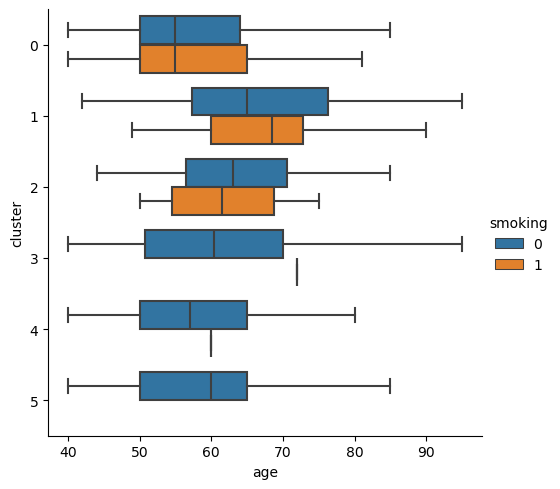

In [24]:
#get_stats_with_box(clinical_df, "age", hue = "smoking")
get_stats_with_box(clin_df, "age", group_by = "cluster", hue = "smoking")

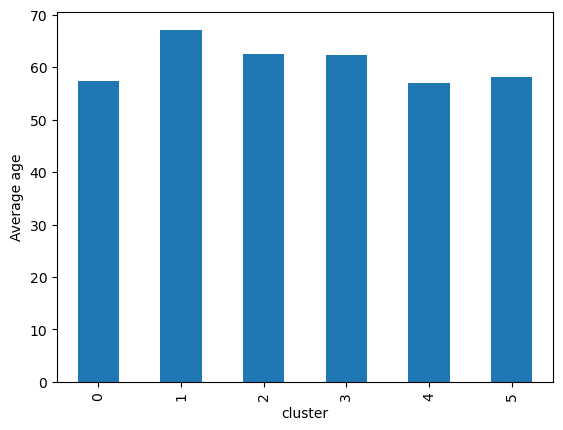

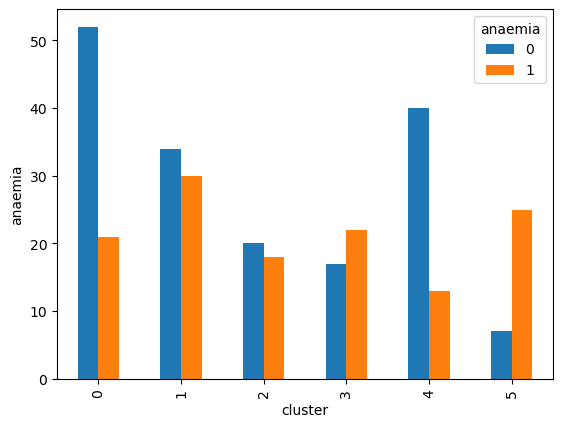

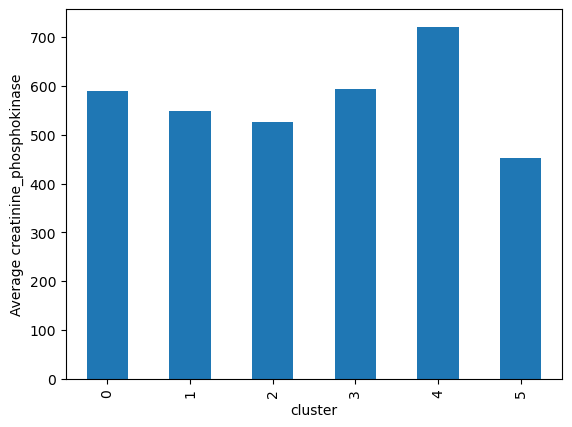

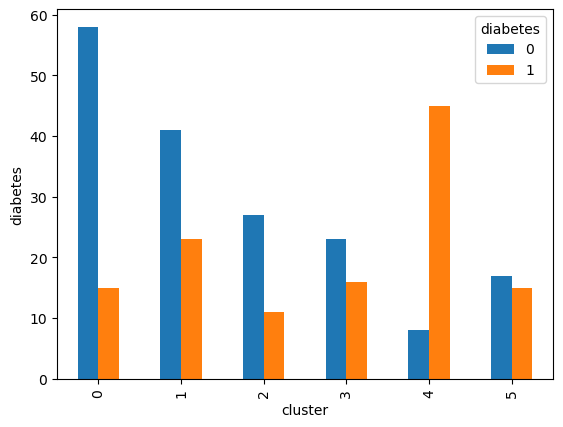

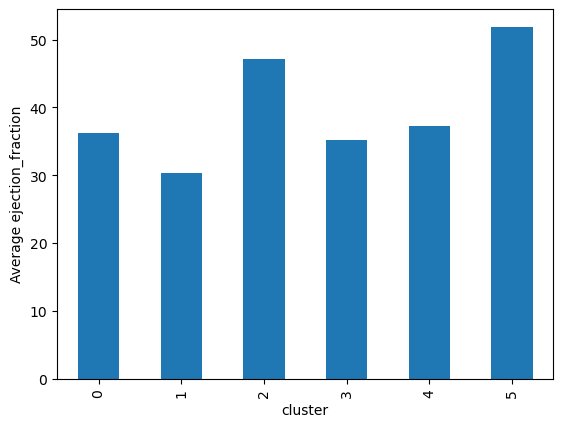

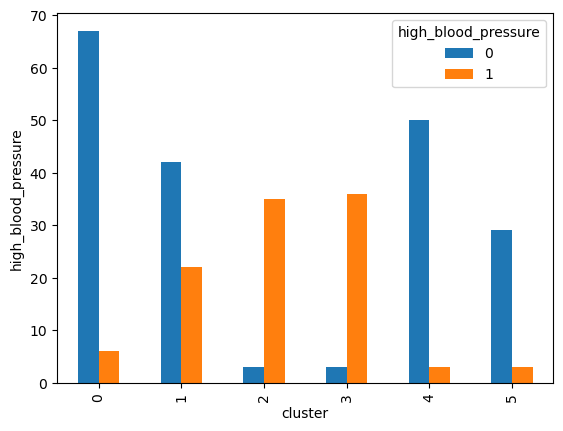

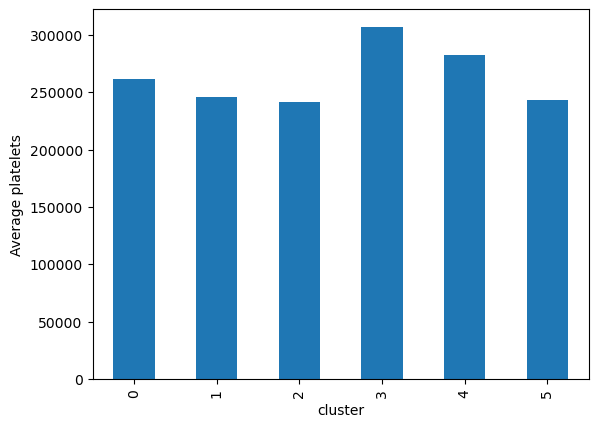

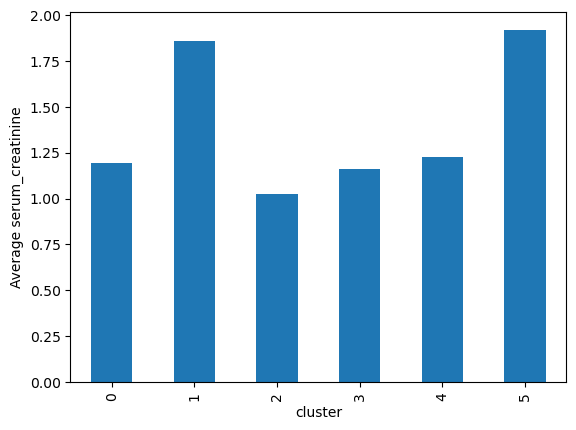

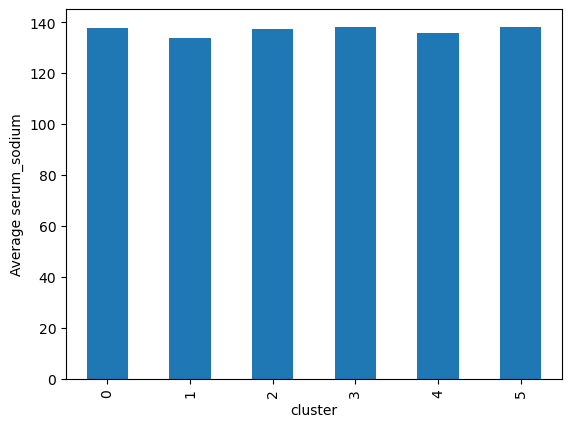

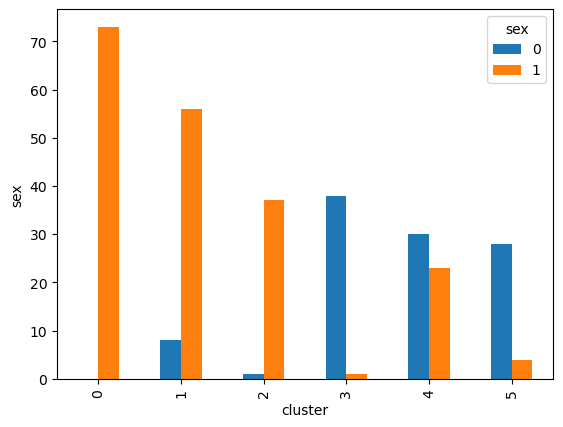

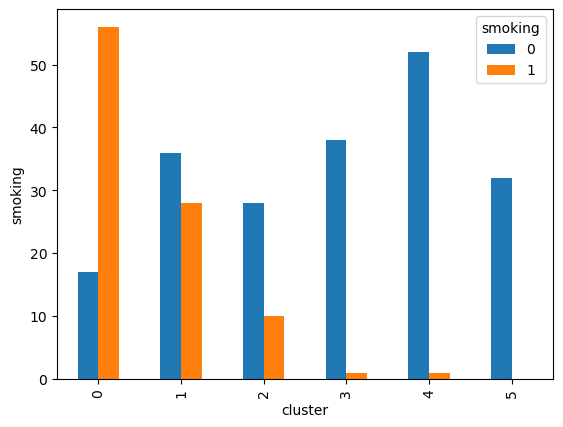

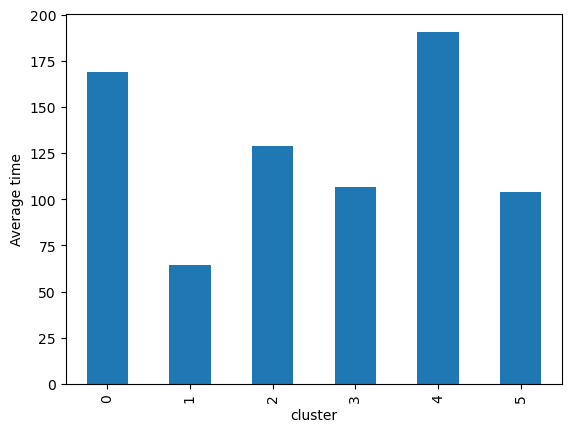

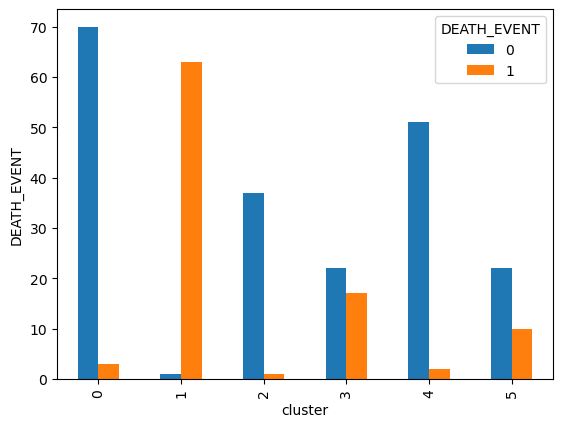

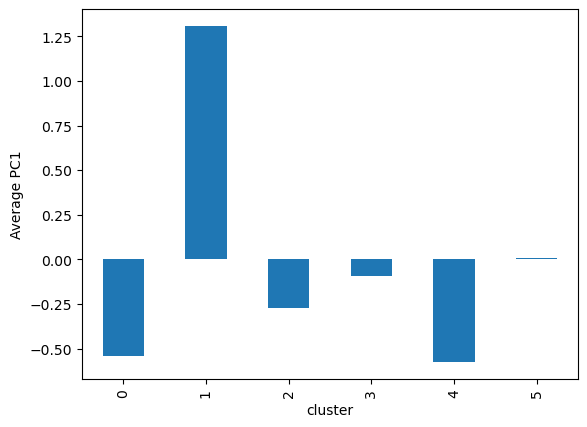

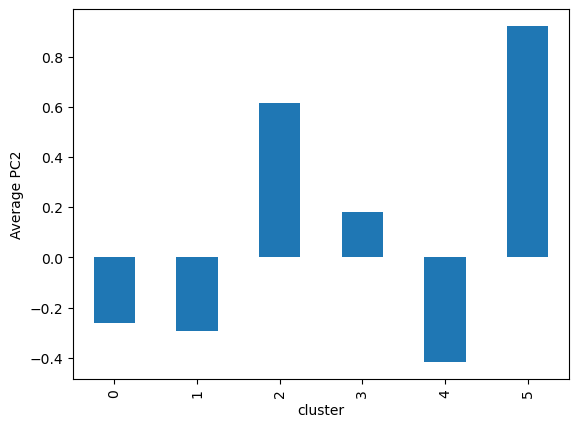

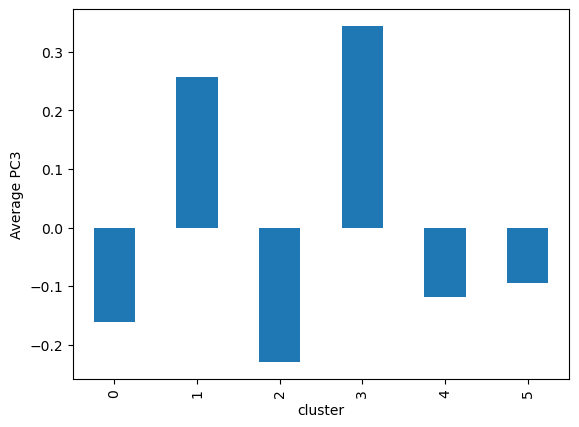

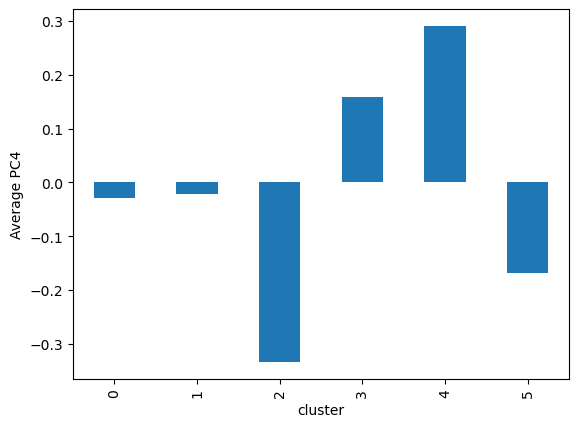

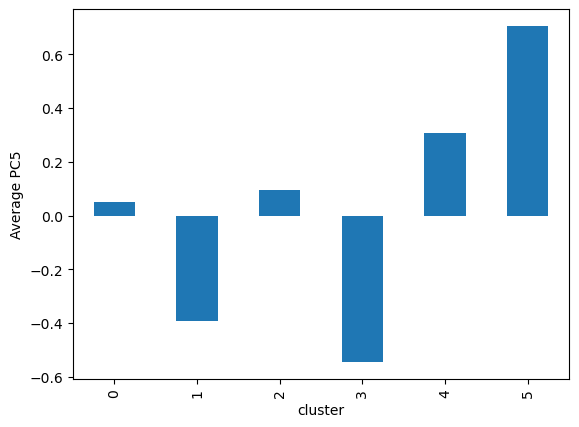

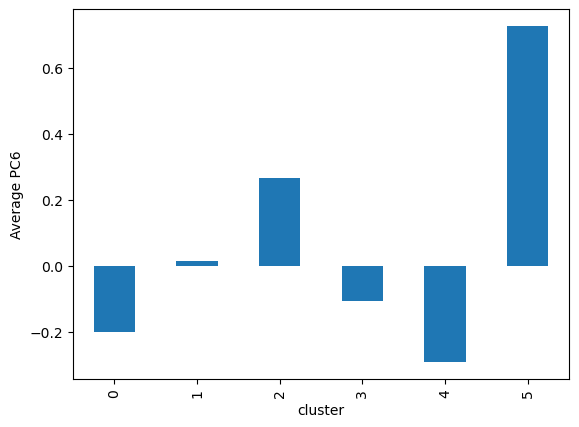

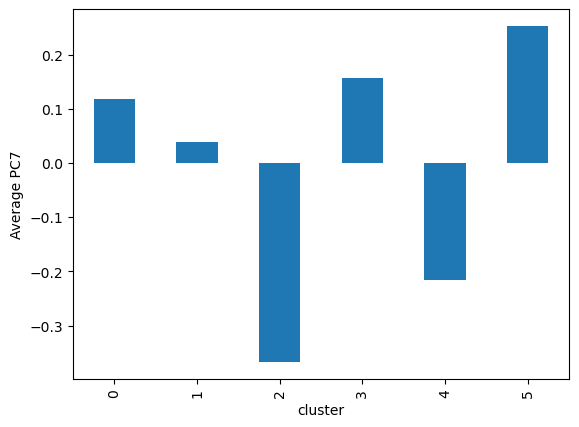

In [25]:
for col in clin_df.columns:
    if col == "cluster":
        continue
    try:
        if col in clin_df.select_dtypes("category").columns:
            _ = clin_df.groupby(by = "cluster")[col].value_counts().unstack().plot.bar(ylabel = col)
            plt.show()
        else:
            _ = clin_df.groupby(by = "cluster")[col].mean().plot.bar(ylabel = "Average %s" % col)
            plt.show()
    except:
        print("Error making box plot with column", col)

In [35]:
print("There was a death event and the patient:")
for death in [0,1]:
    death_mask = (clin_df["DEATH_EVENT"] == death)
    died = "Died" if death else "Survived"
    print("{} patient {}".format( np.sum(death_mask) ,died))
    for (sex, smokes) in [(0,0), (1,0), (0,1), (1,1)]:
        mask = (clin_df["smoking"] == smokes) & (clin_df["sex"] == sex) & death_mask
        gender = "male" if sex else "female"
        smoker = "smoker" if smokes else "not a smoker"
        df = clin_df[mask]
        avg = len(df) / len(clin_df)
        print("\t\tis {} and {}: {:.1f}% ({} people)".format(gender, smoker, 100*avg, len(df)))

There was a death event and the patient:
203 patient Survived
		is female and not a smoker: 23.4% (70 people)
		is male and not a smoker: 22.4% (67 people)
		is female and smoker: 0.3% (1 people)
		is male and smoker: 21.7% (65 people)
96 patient Died
		is female and not a smoker: 10.4% (31 people)
		is male and not a smoker: 11.7% (35 people)
		is female and smoker: 1.0% (3 people)
		is male and smoker: 9.0% (27 people)
